In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms, models # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns # type: ignore
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [34]:
import pickle
import os

def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

# Assuming the extracted files are in the directory 'cifar-10-batches-py'
data_path = 'cifar-10-batches-py'
batch_files = [f'data_batch_{i}' for i in range(1, 6)]
test_file = 'test_batch'

# Load all training batches
train_data = []
train_labels = []

for batch_file in batch_files:
    batch = unpickle(os.path.join(data_path, batch_file))
    train_data.append(batch[b'data'])
    train_labels.extend(batch[b'labels'])

# Convert lists to single arrays
import numpy as np

train_data = np.vstack(train_data)  # Stack into one numpy array
train_labels = np.array(train_labels)

# Load the test batch
test_batch = unpickle(os.path.join(data_path, test_file))
test_data = np.array(test_batch[b'data'])
test_labels = np.array(test_batch[b'labels'])

print(f"Training data shape: {train_data.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Test labels shape: {test_labels.shape}")


Training data shape: (50000, 3072)
Training labels shape: (50000,)
Test data shape: (10000, 3072)
Test labels shape: (10000,)


In [35]:
print(train_data, train_labels)

[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 35  40  42 ...  77  66  50]
 [189 186 185 ... 169 171 171]
 [229 236 234 ... 173 162 161]] [6 9 9 ... 9 1 1]


Convert into pandas dataframe

In [36]:
reshape_train_data = train_data.reshape(50000, 3, 32, 32)
reshape_val_data = test_data.reshape(10000, 3, 32, 32)

pixels_list = reshape_train_data.tolist()
pixels_list_val = reshape_val_data.tolist()

train = pd.DataFrame({
            'pixels': pixels_list,
            'label': train_labels
        })

test = pd.DataFrame({
            'pixels': pixels_list_val,
            'label': test_labels
        })

train['pixels'] = train['pixels'].apply(lambda x: np.array(x) / 255.0)
test['pixels'] = test['pixels'].apply(lambda x: np.array(x) / 255.0)

In [37]:
# For unbalanced training dataset

import pandas as pd
import numpy as np

# Define the random sample sizes for each class (between 1000 and 5000)
np.random.seed(42)  # For reproducibility
sample_sizes = {label: np.random.randint(1000, 5001) for label in train['label'].unique()}

# Select samples for each class based on the randomly chosen sizes
unbalanced_data = pd.concat(
    [train[train['label'] == label].sample(n=size, replace=False, random_state=42)
     for label, size in sample_sizes.items()]
)

# Shuffle the resulting unbalanced DataFrame
unbalanced_data = unbalanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new distribution
print(unbalanced_data['label'].value_counts())


label
8    4772
9    4507
6    4174
3    4092
0    3169
5    2638
1    2294
2    2130
7    2095
4    1860
Name: count, dtype: int64


In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pixels  50000 non-null  object
 1   label   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [39]:
train['label'].value_counts()

label
6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
Name: count, dtype: int64

From here we know the original dataset is balanced and the second dataset is unbalanced

In [40]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import numpy as np
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiClassCNN(nn.Module):
    def __init__(self, first_neuron, number_of_class):
        super(MultiClassCNN, self).__init__()
        
        self.first_out_channels = first_neuron
        
        # Convolutional layers with dropout and batch normalization
        self.features = nn.Sequential(
            # First Convolutional Block
            nn.Conv2d(in_channels=3, out_channels=self.first_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.first_out_channels),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),
            
            # Second Convolutional Block
            nn.Conv2d(in_channels=self.first_out_channels, out_channels=self.first_out_channels*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.first_out_channels*2),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),
            
            # Third Convolutional Block
            nn.Conv2d(in_channels=self.first_out_channels*2, out_channels=self.first_out_channels*4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.first_out_channels*4),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(2),

            # Fourth Convolutional Block
            nn.Conv2d(in_channels=self.first_out_channels*4, out_channels=self.first_out_channels*8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.first_out_channels*8),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(2),
            
            # Global Average Pooling (GAP)
            nn.AdaptiveAvgPool2d(1),  # GAP
        )
        
        # Flatten the output of the GAP layer
        self.flatten_size = self.first_out_channels * 8
        
        # Fully connected classifier with dropout and batch normalization
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(self.flatten_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            
            nn.Dropout(0.4),
            nn.Linear(128, number_of_class),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output of GAP layer
        x = self.classifier(x)
        return x

# Initialize the model
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)

# Data augmentation transforms
def get_train_transforms():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def train_epoch(model, train_loader, criterion, optimizer, device, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device).long()  # Convert labels to long for cross-entropy
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1) # Find maximum value
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device, scheduler=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device).long()  # Convert labels to long for cross-entropy
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total

    if scheduler:
        scheduler.step(epoch_loss)  # Using validation loss here
        
    return epoch_loss, epoch_acc, all_preds, all_labels

In [41]:
import matplotlib.pyplot as plt
from collections import defaultdict

class ModelTracker:
    def __init__(self, model_params):
        self.history = defaultdict(list)
        self.model_params = model_params
    
    def update(self, metrics):
        for key, value in metrics.items():
            self.history[key].append(value)
    
    def get_best_validation_metrics(self):
        val_accs = self.history['val_acc']
        best_acc = max(val_accs)
        best_epoch = val_accs.index(best_acc) + 1  # +1 because epochs start from 1
        return best_acc, best_epoch
    
    def plot_metrics(self):
        """Plot training and validation metrics with parameters."""
        # Create figure with custom layout
        fig = plt.figure(figsize=(20, 10))
        
        # Create grid spec for custom layout
        gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 1])
        
        # Loss subplot
        ax1 = fig.add_subplot(gs[0, 0])
        epochs = range(1, len(self.history['train_loss']) + 1)
        ax1.plot(epochs, self.history['train_loss'], 'b-', label='Training Loss', marker='o')
        ax1.plot(epochs, self.history['val_loss'], 'r-', label='Validation Loss', marker='o')
        ax1.set_title('Model Loss', fontsize=12, pad=10)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='upper right')
        ax1.grid(True, linestyle='--', alpha=0.7)
        
        # Accuracy subplot
        ax2 = fig.add_subplot(gs[1, 0])
        ax2.plot(epochs, self.history['train_acc'], 'b-', label='Training Accuracy', marker='o')
        ax2.plot(epochs, self.history['val_acc'], 'r-', label='Validation Accuracy', marker='o')
        ax2.set_title('Model Accuracy', fontsize=12, pad=10)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend(loc='lower right')
        ax2.grid(True, linestyle='--', alpha=0.7)
        
        # Parameters text box
        params_ax = fig.add_subplot(gs[:, 1])
        params_ax.axis('off')
        
        # Create parameter text
        params_text = "Model Parameters:\n" + "="*30 + "\n"
        for param, value in self.model_params.items():
            params_text += f"{param:<20}: {value}\n"
        
        # Add overfitting analysis
        overfitting_analysis = self.check_overfitting()
        params_text += "\nOverfitting Analysis:\n" + "="*30 + "\n"
        params_text += overfitting_analysis
        
        # Get best validation metrics
        best_val_acc, best_epoch = self.get_best_validation_metrics()
        
        # Add final metrics
        params_text += "\n\nFinal Metrics:\n" + "="*30 + "\n"
        params_text += f"Training Loss: {self.history['train_loss'][-1]:.4f}\n"
        params_text += f"Validation Loss: {self.history['val_loss'][-1]:.4f}\n"
        params_text += f"Training Accuracy: {self.history['train_acc'][-1]:.4f}%\n"
        params_text += f"Validation Accuracy: {self.history['val_acc'][-1]:.4f}%\n"
        params_text += f"\nBest Validation Accuracy: {best_val_acc:.4f}%\n"
        params_text += f"Best Validation Epoch: {best_epoch}"
        
        # Add text to figure
        params_ax.text(0, 0.95, params_text, transform=params_ax.transAxes,
                      fontsize=10, verticalalignment='top',
                      family='monospace', bbox=dict(facecolor='white', 
                                                  alpha=0.8,
                                                  edgecolor='gray',
                                                  boxstyle='round,pad=1'))
        
        # Add timestamp and title
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        fig.suptitle(f"Training Results - {timestamp}", fontsize=14, y=0.98)
        
        plt.tight_layout()
        plt.show()
        return fig
    
    def check_overfitting(self, threshold=5):
        """Check for signs of overfitting"""
        if len(self.history['train_acc']) < 2:
            return "Not enough epochs to determine overfitting"
        
        train_acc = self.history['train_acc'][-1]
        val_acc = self.history['val_acc'][-1]
        acc_diff = train_acc - val_acc
        
        val_loss_trend = self.history['val_loss'][-3:]  # Last 3 epochs
        
        analysis = []
        if acc_diff > threshold:
            analysis.append(f"Warning: Training accuracy exceeds\nvalidation accuracy by {acc_diff:.2f}%")
        
        if len(val_loss_trend) == 3 and all(val_loss_trend[i] > val_loss_trend[i-1] for i in range(1, len(val_loss_trend))):
            analysis.append("Warning: Validation loss is\nconsistently increasing")
            
        return "\n".join(analysis) if analysis else "No clear signs of overfitting detected"

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, scheduler=None):
    # Define model parameters
    model_params = {
        "Batch Size": train_loader.batch_size,
        "Learning Rate": optimizer.param_groups[0]['lr'],
        "Epochs": num_epochs,
        "Criterion": criterion.__class__.__name__,
        "Optimizer": optimizer.__class__.__name__,
        "First Out Channels": model.first_out_channels,
        "Model Architecture": "CatDogCNN",
        "Device": device,
        "Total Parameters": sum(p.numel() for p in model.parameters()),
        "Trainable Parameters": sum(p.numel() for p in model.parameters() if p.requires_grad)
    }
    
    tracker = ModelTracker(model_params)
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device,scheduler)
        
        # Validation
        val_loss, val_acc, val_pred, val_labels = validate(model, val_loader, criterion, device, scheduler)
        
        # Update metrics
        metrics = {
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        }
        tracker.update(metrics)
        
        # Print epoch results
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
    
    # Plot final results
    fig = tracker.plot_metrics()

    # Save the figure
    output_dir = "Final_Image"
    os.makedirs(output_dir, exist_ok=True)

    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    file_path = os.path.join(output_dir, f"Training Results - {timestamp}.jpg")
    fig.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    return tracker

In [42]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import DataLoader

# Assuming you already have pixel_data and labels as numpy arrays
pixel_data = np.array(unbalanced_data['pixels'].tolist())
labels = np.array(unbalanced_data['label'].tolist())
X = torch.tensor(pixel_data, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)

test_pixel_data = np.array(test['pixels'].tolist())
test_labels = np.array(test['label'].tolist())
val_X = torch.tensor(test_pixel_data, dtype=torch.float32)
val_y = torch.tensor(test_labels, dtype=torch.long)

In [43]:
print(X.shape, y.shape)

torch.Size([31731, 3, 32, 32]) torch.Size([31731])


In [44]:
train_transforms = get_train_transforms()

augmented_images = []
for img in X:
    img = transforms.ToPILImage()(img)           # Convert tensor to PIL image for augmentation
    augmented_img = train_transforms(img)         # Apply augmentation
    augmented_images.append(augmented_img)        # Store augmented image

val_augmented_images = []
for img in val_X:
    img = transforms.ToPILImage()(img)           # Convert tensor to PIL image for augmentation
    val_augmented_img = train_transforms(img)         # Apply augmentation
    val_augmented_images.append(val_augmented_img)

augmented_images = torch.stack(augmented_images)
val_augmented_images = torch.stack(val_augmented_images)

combined_images = torch.cat([X, augmented_images], dim=0)
combined_labels = torch.cat([y, y], dim=0)  # Duplicate labels as well
print(combined_images.shape, combined_labels.shape)

val_combined_images = torch.cat([val_X, val_augmented_images], dim=0)
val_combined_labels = torch.cat([val_y, val_y], dim=0)  # Duplicate labels as well

train_dataset = TensorDataset(combined_images, combined_labels)
val_dataset = TensorDataset(val_combined_images, val_combined_labels)

torch.Size([63462, 3, 32, 32]) torch.Size([63462])



Epoch 1/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 192.56it/s]


Train Loss: 2.0408, Train Acc: 30.34%
Validation Loss: 1.7144, Validation Acc: 32.17%

Epoch 2/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 210.05it/s]


Train Loss: 1.5381, Train Acc: 44.43%
Validation Loss: 1.4074, Validation Acc: 46.40%

Epoch 3/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 211.33it/s]


Train Loss: 1.2659, Train Acc: 55.25%
Validation Loss: 1.1409, Validation Acc: 58.26%

Epoch 4/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 212.86it/s]


Train Loss: 1.0747, Train Acc: 62.25%
Validation Loss: 1.0224, Validation Acc: 63.40%

Epoch 5/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 210.33it/s]


Train Loss: 0.9632, Train Acc: 66.55%
Validation Loss: 0.9037, Validation Acc: 68.11%

Epoch 6/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 210.72it/s]


Train Loss: 0.8695, Train Acc: 70.09%
Validation Loss: 0.8386, Validation Acc: 70.61%

Epoch 7/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 215.90it/s]


Train Loss: 0.8013, Train Acc: 72.71%
Validation Loss: 0.9211, Validation Acc: 67.67%

Epoch 8/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 211.33it/s]


Train Loss: 0.7351, Train Acc: 74.96%
Validation Loss: 0.7498, Validation Acc: 74.38%

Epoch 9/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 211.87it/s]


Train Loss: 0.6796, Train Acc: 77.10%
Validation Loss: 0.7066, Validation Acc: 76.19%

Epoch 10/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 200.13it/s]


Train Loss: 0.6331, Train Acc: 78.65%
Validation Loss: 0.6684, Validation Acc: 77.53%

Epoch 11/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 213.91it/s]


Train Loss: 0.5936, Train Acc: 80.03%
Validation Loss: 0.6656, Validation Acc: 77.42%

Epoch 12/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 214.56it/s]


Train Loss: 0.5484, Train Acc: 81.47%
Validation Loss: 0.6534, Validation Acc: 78.04%

Epoch 13/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 215.23it/s]


Train Loss: 0.5166, Train Acc: 82.65%
Validation Loss: 0.6374, Validation Acc: 78.83%

Epoch 14/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 212.26it/s]


Train Loss: 0.4926, Train Acc: 83.56%
Validation Loss: 0.6367, Validation Acc: 78.99%

Epoch 15/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 209.54it/s]


Train Loss: 0.4577, Train Acc: 84.64%
Validation Loss: 0.7417, Validation Acc: 75.72%

Epoch 16/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 215.60it/s]


Train Loss: 0.4347, Train Acc: 85.35%
Validation Loss: 0.6202, Validation Acc: 79.89%

Epoch 17/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 214.16it/s]


Train Loss: 0.4121, Train Acc: 86.07%
Validation Loss: 0.6443, Validation Acc: 79.23%

Epoch 18/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 207.83it/s]


Train Loss: 0.3961, Train Acc: 86.72%
Validation Loss: 0.6100, Validation Acc: 80.28%


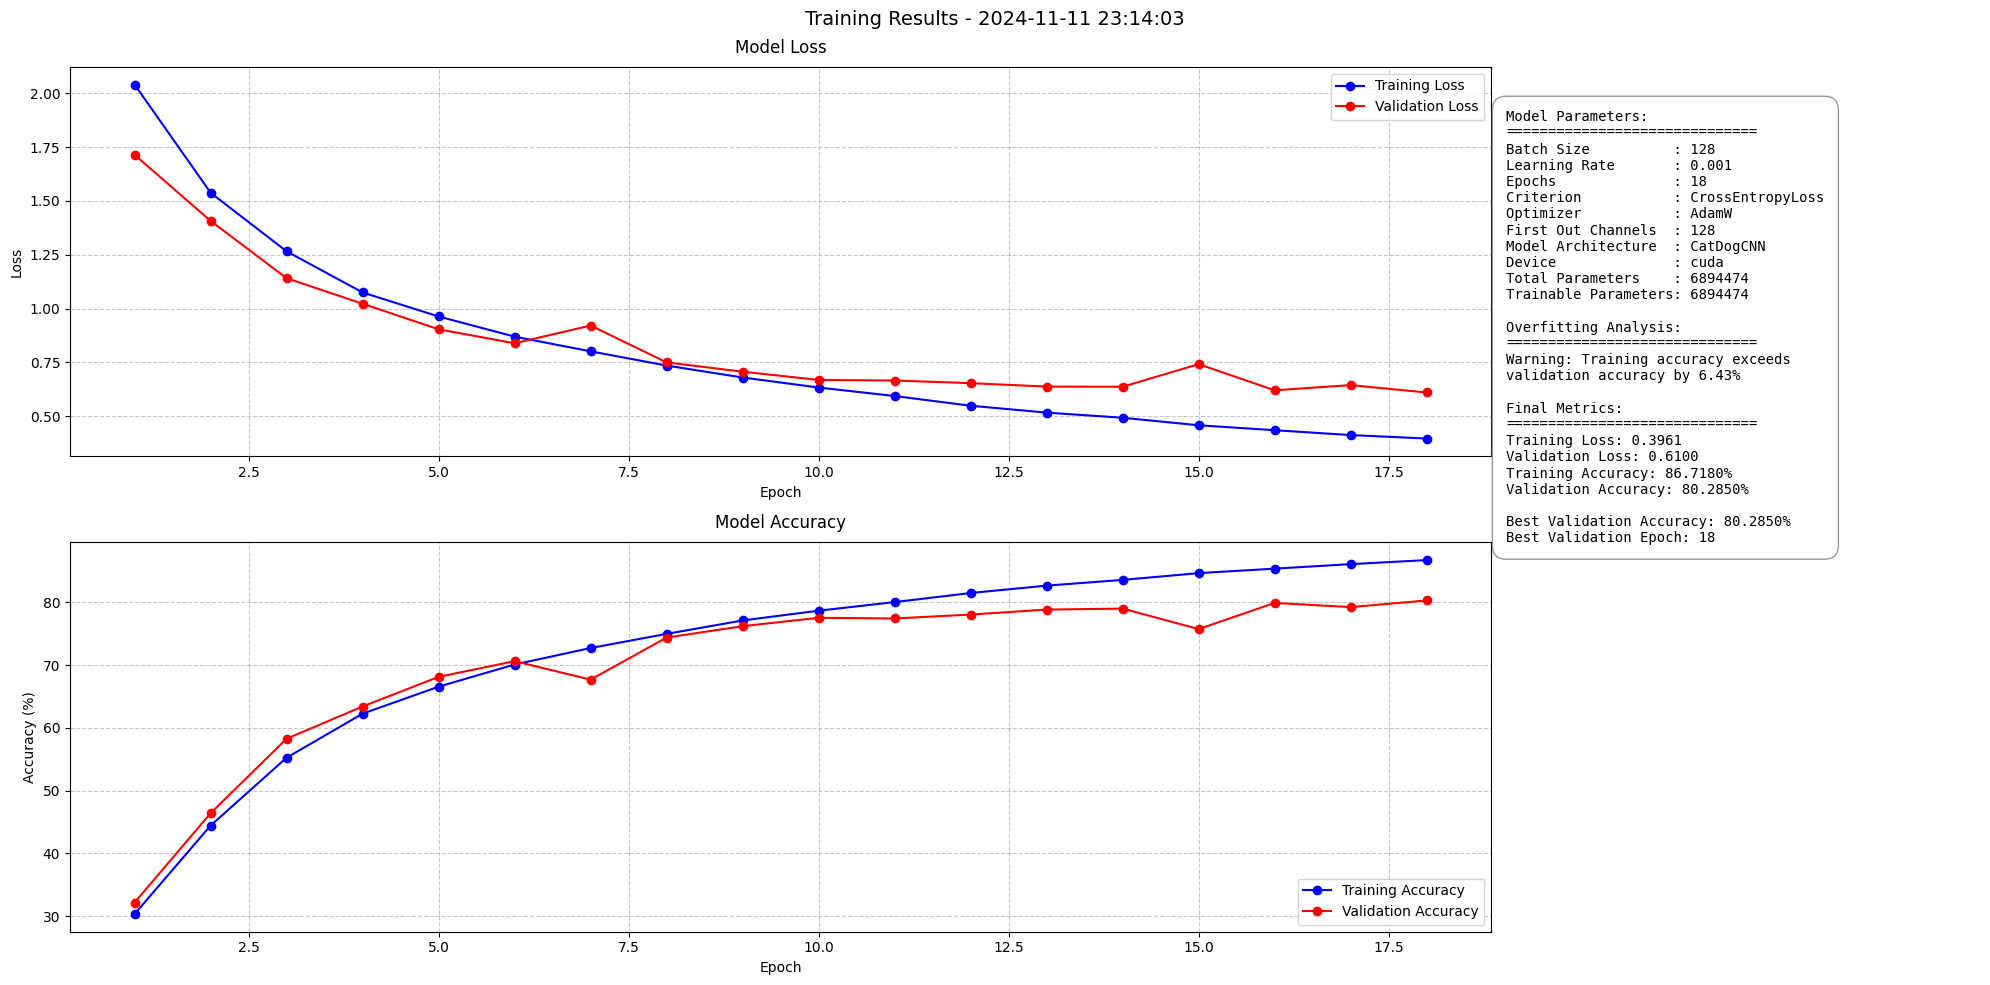

In [21]:
# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

# Initialize model, criterion, optimizer
model = MultiClassCNN(first_neuron=128, number_of_class=10).to(device)
model.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=  0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=18,
        device=device,
        scheduler=scheduler
    )

Grid Search

Journal:

A. Use 32 batch with 32 first out neuron and 0.001 lr and 10 epochs
1. Testing using 3 cnn block with SGD (acc 62.74 % bad) -> default momentum
2. Testing using 3 cnn block with Adam (acc 78.89 %) -> ***Choose this***
3. Testing using 3 cnn block with SGD (acc 76.96 % bad) -> 0.9 momentum
4. Testing using 3 cnn block with RMSprop (Root Mean Square Propagation) (78.51 %)
5. Testing using 3 cnn block with Adagrad (Adaptive Gradient Algorithm) (78.01 %) -> using 0.01 lr
6. Testing using 3 cnn block with Adadelta (48.42 %)
7. Testing using 3 cnn block with AdamW (78.48 %)

We will choose Adam as the optimization function

B. Use 32 batch with 32 first neuron and 0.001 lr and 10 epochs on Adam
1. Testing using 2 cnn block (74.84 %)
2. Testing with 4 cnn block (78.34 %) 

C. Changing Model architecture and also using image augmentation and normalize the numerical value (under 10 epochs)
1. Using normal 3 cnn blocks (75.44%) -> no sign of overfitting
2. Using 4 cnn blocks (77.85%) -> no sign of overfitting
3. Using 4 cnn blocks and changing the drop to 0.3 and also the linear layer from 512 to 256 (using 4 stage layer drop) -> (77.78%)
4. Using 5 cnn blocks (76.70) -> trainig time too long

D. Changing neurons -> under 20 epochs to see overfitting

5. Using batch size of 128 and second neurons of 128 (stuck in 83%) -> starting to get overfit (lr 0.0005) train acc 88%
6. Using batch size of 128 and second neurons of 128 (stuck in 83% but can reach 84%) -> starting to get overfit (lr 0.001)
7. Using 256 second neurons (82%)
8. Adding GAP and init weight (128 neuron) -> 84% but loss is increasing
9. Adding scheduler (around 83%)
10. Using LeakyReLU (not good)
11. Using batch train 32 to increase noise (bad)

Final Conclusion:

What Changed:
1. We use image augmentation making train dataset has 100k rows
2. Normalize the image so range value is from 0 to 1
3. We decide to use 4 cnn blocks and also add more linear layer
4. We use wight inizialization with kaiming and xavier
5. Use learning rate scheduling with ReduceLROnPlateau
6. We use batch size 128 with 128 second neurons and also 0.001 learning rate
7. We use Global Average Pooling (GAP)

* We are using grid search but not for different dataset (we only use original dataset with 50k coloumns to have a rough idea on the parameter contribution) -> please look at cifer10-grid search folder and also cifer-10 csv for better clearence.

We are not using grid search for this as it only making minor changes and we rather focus on improving the overall model architecture and try to fix the overfitting which always happend in the grid search before.

Reasons to use certain parameter:
1. 128 second neuron in order for the model to learn better
2. 128 batch size in order for the model to see more image in 1 cycle
3. learning rate 0.001 is the most consistent compare to 0.0005 and 0.005
4. we use learning rate schedu;ing to control the learning rate and also we sure weight inizialization to make the model learn better

* Take note that all of these is run with random seed to test the consistencies
please run cifer.py for reproducing purpose.

# For Unbalanced Dataset

1. Class-Weighted Loss Function


Epoch 1/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 197.16it/s]


Train Loss: 2.1835, Train Acc: 23.61%
Validation Loss: 1.7321, Validation Acc: 37.45%

Epoch 2/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 206.42it/s]


Train Loss: 1.6694, Train Acc: 37.20%
Validation Loss: 1.4671, Validation Acc: 46.48%

Epoch 3/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 202.89it/s]


Train Loss: 1.4035, Train Acc: 48.75%
Validation Loss: 1.2076, Validation Acc: 55.10%

Epoch 4/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 231.56it/s]


Train Loss: 1.1971, Train Acc: 57.60%
Validation Loss: 1.0024, Validation Acc: 64.25%

Epoch 5/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 212.79it/s]


Train Loss: 1.0498, Train Acc: 63.42%
Validation Loss: 0.9447, Validation Acc: 66.40%

Epoch 6/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 213.76it/s]


Train Loss: 0.9471, Train Acc: 67.42%
Validation Loss: 0.8307, Validation Acc: 71.62%

Epoch 7/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 201.21it/s]


Train Loss: 0.8624, Train Acc: 70.76%
Validation Loss: 0.7913, Validation Acc: 72.14%

Epoch 8/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 220.24it/s]


Train Loss: 0.7975, Train Acc: 73.21%
Validation Loss: 0.7541, Validation Acc: 74.55%

Epoch 9/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 207.56it/s]


Train Loss: 0.7363, Train Acc: 75.07%
Validation Loss: 0.7712, Validation Acc: 75.05%

Epoch 10/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 209.10it/s]


Train Loss: 0.6824, Train Acc: 76.88%
Validation Loss: 0.6717, Validation Acc: 78.16%

Epoch 11/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 196.85it/s]


Train Loss: 0.6350, Train Acc: 78.59%
Validation Loss: 0.6403, Validation Acc: 78.73%

Epoch 12/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 221.77it/s]


Train Loss: 0.5944, Train Acc: 79.95%
Validation Loss: 0.6527, Validation Acc: 78.77%

Epoch 13/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 205.00it/s]


Train Loss: 0.5610, Train Acc: 80.98%
Validation Loss: 0.6499, Validation Acc: 79.42%

Epoch 14/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 207.46it/s]


Train Loss: 0.5253, Train Acc: 82.16%
Validation Loss: 0.6382, Validation Acc: 80.00%

Epoch 15/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 200.09it/s]


Train Loss: 0.4944, Train Acc: 83.26%
Validation Loss: 0.6617, Validation Acc: 79.11%

Epoch 16/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 225.91it/s]


Train Loss: 0.4764, Train Acc: 83.69%
Validation Loss: 0.6785, Validation Acc: 78.64%

Epoch 17/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 209.45it/s]


Train Loss: 0.4369, Train Acc: 85.04%
Validation Loss: 0.6431, Validation Acc: 80.08%

Epoch 18/18


Validation: 100%|██████████| 157/157 [00:00<00:00, 208.97it/s]


Train Loss: 0.4206, Train Acc: 85.56%
Validation Loss: 0.6475, Validation Acc: 80.34%


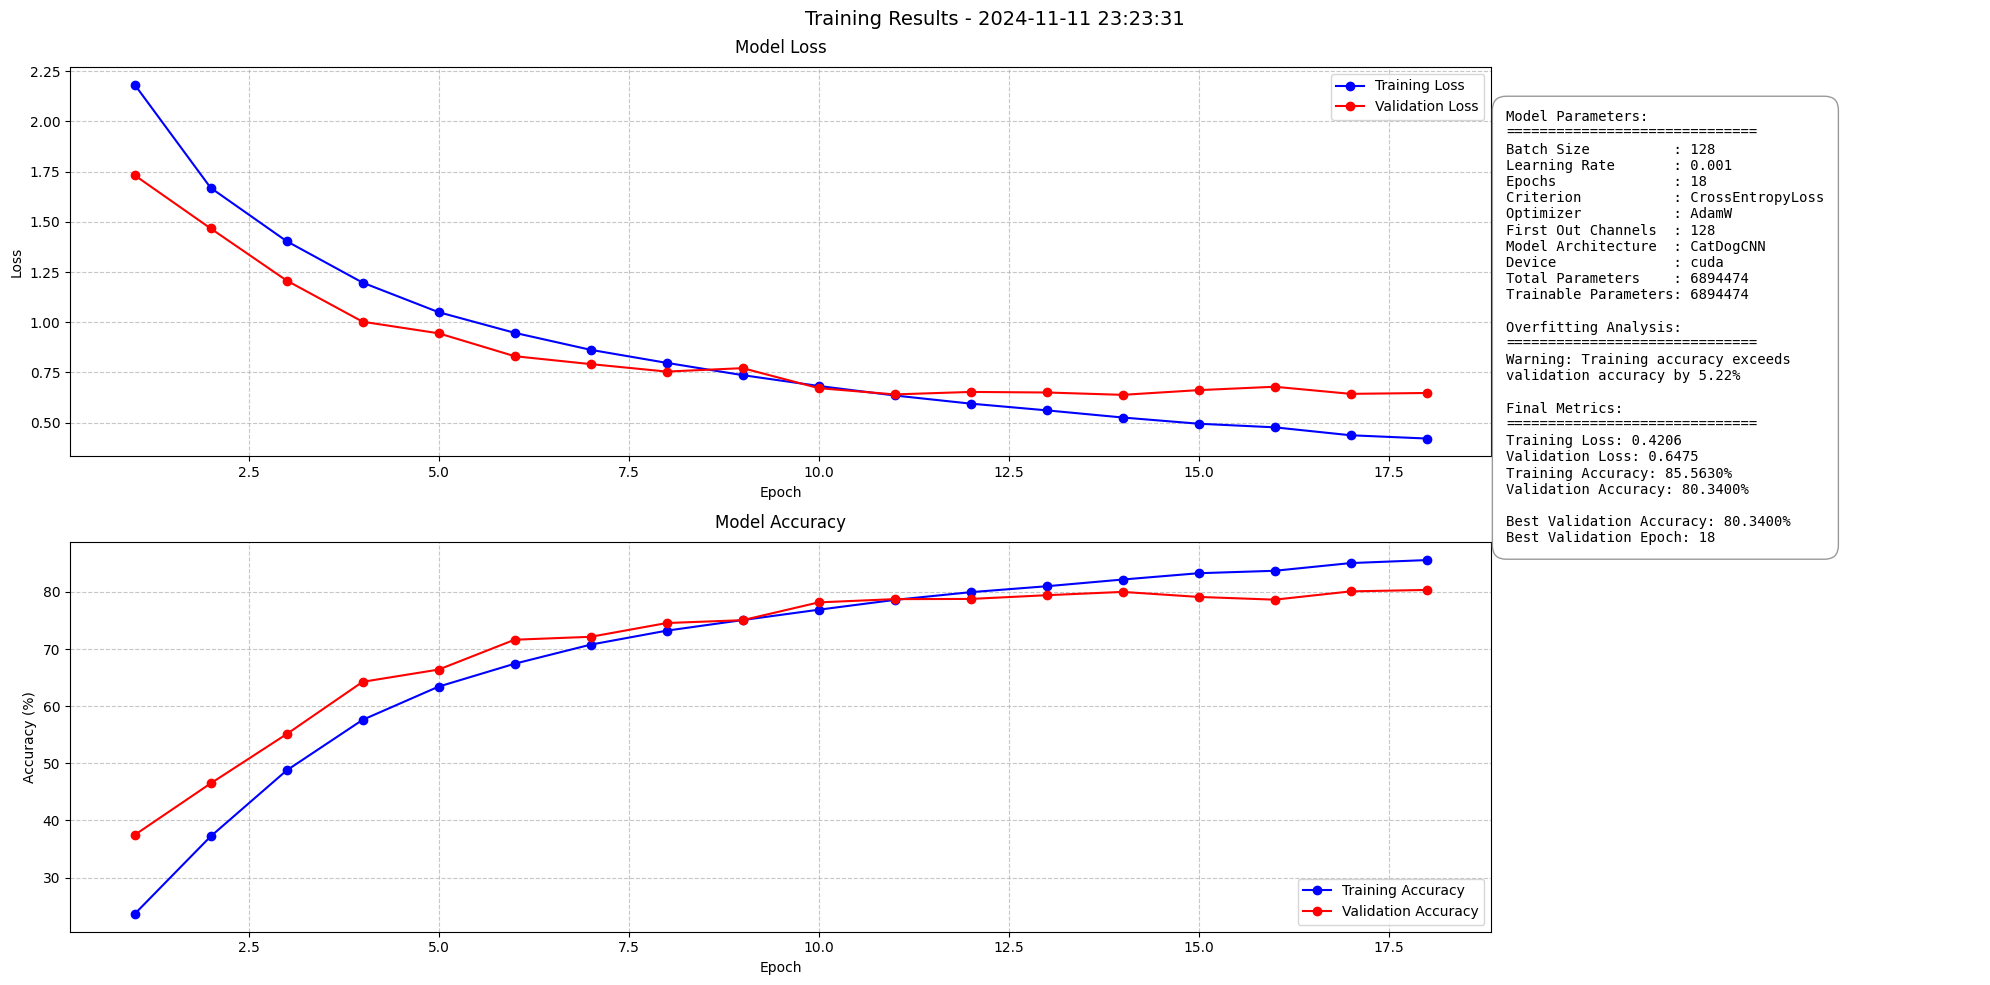

In [23]:
import torch
import torch.nn as nn

# Define class counts
class_counts = torch.tensor([3169, 2294, 2130, 4092, 2638, 1860, 4174, 2095, 4772, 4507], dtype=torch.float).to(device)

# Calculate weights as the inverse of class frequency
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()  # Normalize the weights

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

# Initialize model, criterion, optimizer
model = MultiClassCNN(first_neuron=128, number_of_class=10).to(device)
model.apply(init_weights)

# Apply these weights in CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=  0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=18,
        device=device,
        scheduler=scheduler
    )

2. Image Augmentation to Handle under-representing class

Class distribution: tensor([6338, 4588, 4260, 8184, 3720, 5276, 8348, 4190, 9544, 9014])
Under-represented classes: [1, 2, 4, 7]
Train dataset size after augmentation: 80220
Validation dataset size: 20000

Epoch 1/18


Validation: 100%|██████████| 313/313 [00:00<00:00, 351.06it/s]


Train Loss: 1.9568, Train Acc: 29.25%
Validation Loss: 1.6299, Validation Acc: 38.41%

Epoch 2/18


Validation: 100%|██████████| 313/313 [00:00<00:00, 415.18it/s]


Train Loss: 1.4482, Train Acc: 46.03%
Validation Loss: 1.2141, Validation Acc: 55.67%

Epoch 3/18


Validation: 100%|██████████| 313/313 [00:00<00:00, 434.73it/s]


Train Loss: 1.2072, Train Acc: 55.82%
Validation Loss: 1.0482, Validation Acc: 61.92%

Epoch 4/18


Validation: 100%|██████████| 313/313 [00:00<00:00, 435.37it/s]


Train Loss: 1.0671, Train Acc: 61.41%
Validation Loss: 0.8838, Validation Acc: 68.34%

Epoch 5/18


Validation: 100%|██████████| 313/313 [00:00<00:00, 442.31it/s]


Train Loss: 0.9619, Train Acc: 65.67%
Validation Loss: 0.8374, Validation Acc: 70.42%

Epoch 6/18


Validation: 100%|██████████| 313/313 [00:00<00:00, 443.47it/s]


Train Loss: 0.8847, Train Acc: 68.57%
Validation Loss: 0.7722, Validation Acc: 73.21%

Epoch 7/18


Validation: 100%|██████████| 313/313 [00:00<00:00, 442.91it/s]


Train Loss: 0.8169, Train Acc: 71.02%
Validation Loss: 0.7482, Validation Acc: 74.01%

Epoch 8/18


Validation: 100%|██████████| 313/313 [00:00<00:00, 451.58it/s]


Train Loss: 0.7599, Train Acc: 73.21%
Validation Loss: 0.6768, Validation Acc: 76.62%

Epoch 9/18


Validation: 100%|██████████| 313/313 [00:00<00:00, 451.99it/s]


Train Loss: 0.7183, Train Acc: 74.83%
Validation Loss: 0.6790, Validation Acc: 76.58%

Epoch 10/18


Validation: 100%|██████████| 313/313 [00:00<00:00, 443.45it/s]


Train Loss: 0.6766, Train Acc: 76.35%
Validation Loss: 0.6478, Validation Acc: 78.06%

Epoch 11/18


Validation: 100%|██████████| 313/313 [00:00<00:00, 448.34it/s]


Train Loss: 0.6446, Train Acc: 77.23%
Validation Loss: 0.6231, Validation Acc: 78.78%

Epoch 12/18


Validation: 100%|██████████| 313/313 [00:00<00:00, 441.54it/s]


Train Loss: 0.6103, Train Acc: 78.54%
Validation Loss: 0.6109, Validation Acc: 79.25%

Epoch 13/18


Validation: 100%|██████████| 313/313 [00:00<00:00, 462.56it/s]


Train Loss: 0.5805, Train Acc: 79.60%
Validation Loss: 0.5999, Validation Acc: 79.69%

Epoch 14/18


Validation: 100%|██████████| 313/313 [00:00<00:00, 438.11it/s]


Train Loss: 0.5584, Train Acc: 80.31%
Validation Loss: 0.6090, Validation Acc: 79.58%

Epoch 15/18


Validation: 100%|██████████| 313/313 [00:00<00:00, 425.09it/s]


Train Loss: 0.5314, Train Acc: 81.41%
Validation Loss: 0.6211, Validation Acc: 79.46%

Epoch 16/18


Validation: 100%|██████████| 313/313 [00:00<00:00, 441.11it/s]


Train Loss: 0.5114, Train Acc: 81.93%
Validation Loss: 0.5861, Validation Acc: 80.39%

Epoch 17/18


Validation: 100%|██████████| 313/313 [00:00<00:00, 441.62it/s]


Train Loss: 0.4899, Train Acc: 82.85%
Validation Loss: 0.5862, Validation Acc: 80.74%

Epoch 18/18


Validation: 100%|██████████| 313/313 [00:00<00:00, 431.42it/s]


Train Loss: 0.4698, Train Acc: 83.46%
Validation Loss: 0.6167, Validation Acc: 79.76%


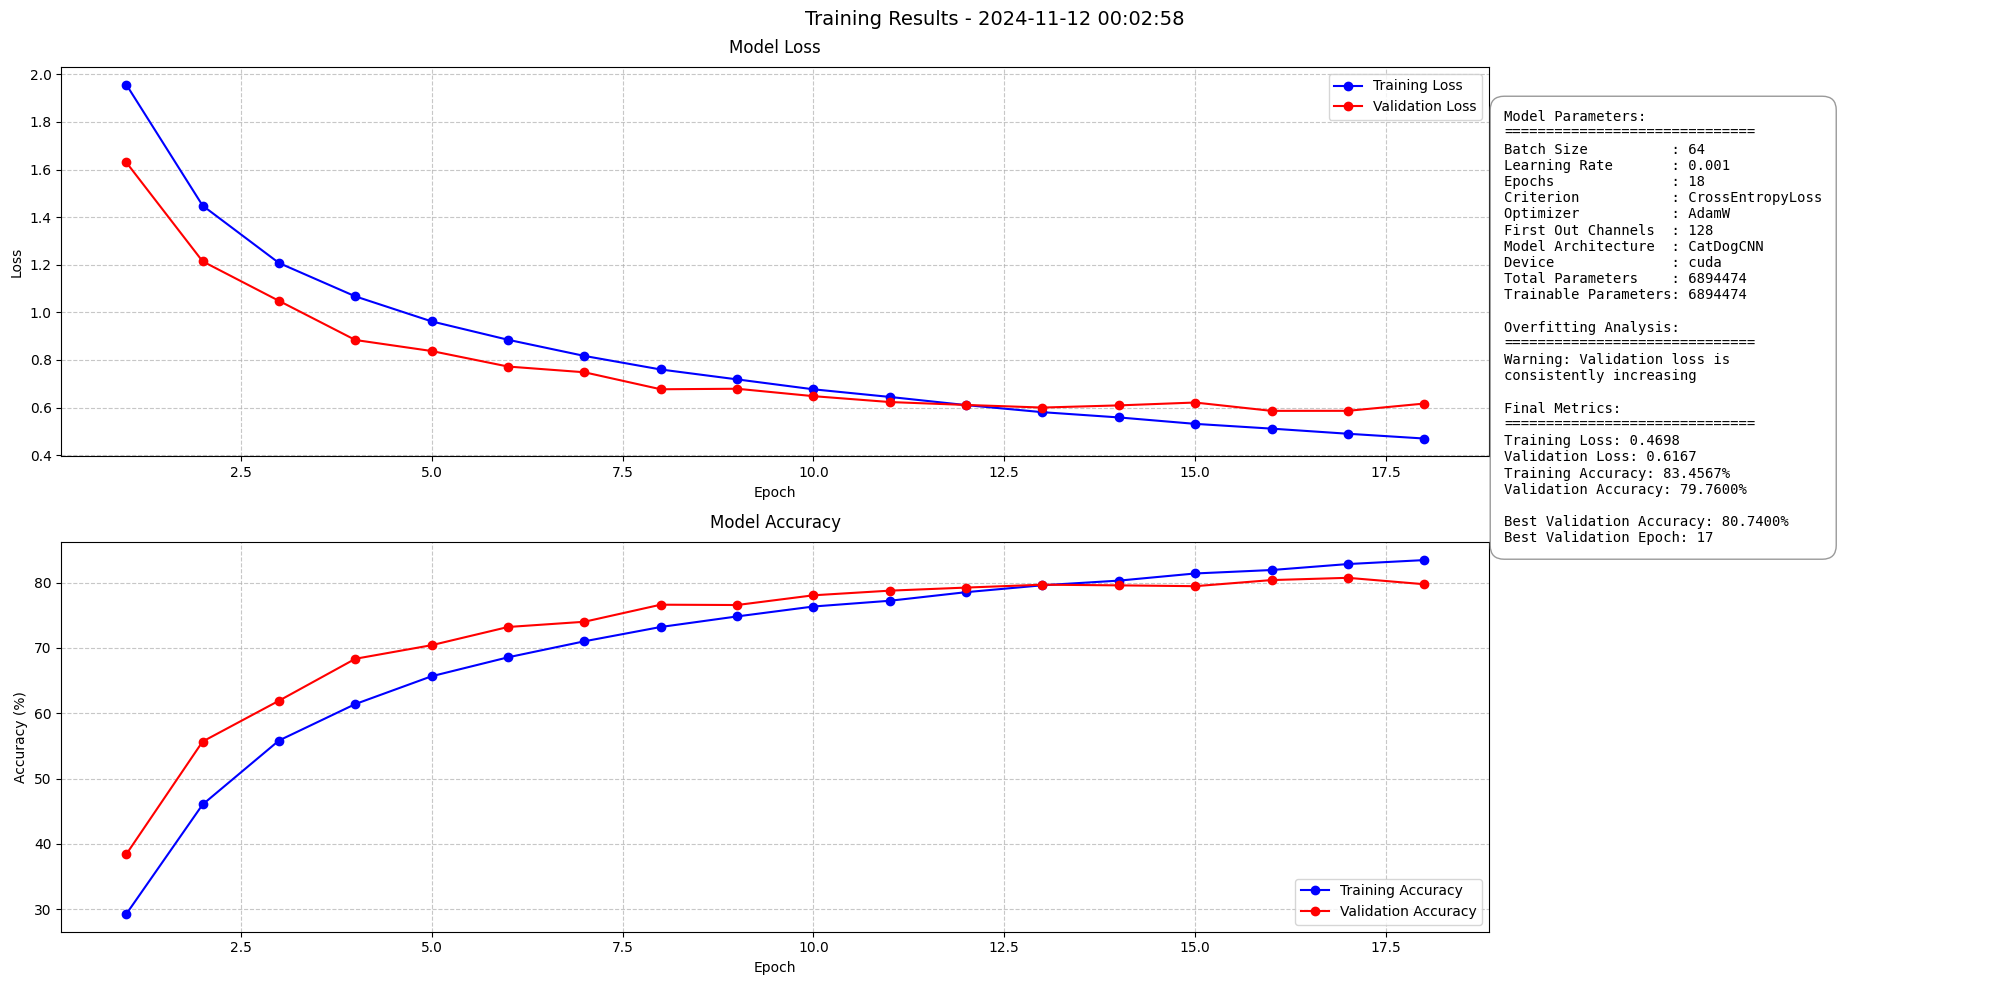

In [45]:
import torch
from torch.utils.data import TensorDataset
import torchvision.transforms as transforms

def augment_underrepresented_classes(train_dataset, val_dataset, train_transforms, target_class_count):
    # Extract images and labels from train_dataset
    train_images, train_labels = train_dataset[:]
    
    # Calculate the count of each class in the train dataset
    class_counts = torch.bincount(train_labels, minlength=10)  # 10 classes, adjust for your number of classes
    print("Class distribution:", class_counts)
    
    # Find under-represented classes (those with fewer than the target count)
    underrepresented_classes = [i for i, count in enumerate(class_counts) if count < target_class_count]
    print("Under-represented classes:", underrepresented_classes)
    
    # Create a list to hold augmented images and their labels
    augmented_images = []
    augmented_labels = []
    
    # Augment images of under-represented classes
    for i, label in enumerate(train_labels):
        if label.item() in underrepresented_classes:
            img = train_images[i]
            img = transforms.ToPILImage()(img)  # Convert tensor to PIL image for augmentation
            augmented_img = train_transforms(img)  # Apply augmentation
            augmented_images.append(augmented_img)  # Store augmented image
            augmented_labels.append(label)  # Store corresponding label
    
    # Convert augmented images and labels back to tensors
    augmented_images = torch.stack(augmented_images)
    augmented_labels = torch.tensor(augmented_labels, dtype=torch.long)
    
    # Combine original dataset with augmented data
    combined_images = torch.cat([train_images, augmented_images], dim=0)
    combined_labels = torch.cat([train_labels, augmented_labels], dim=0)
    
    # Create the new train dataset with augmented data
    augmented_train_dataset = TensorDataset(combined_images, combined_labels)
    
    # For validation, no augmentation is performed; just return the dataset as is
    return augmented_train_dataset, val_dataset

# Example usage
# Set target_class_count to the maximum class size to balance all classes to the size of the largest class
target_class_count = max(torch.bincount(y))  # Set target count to the maximum class size
train_dataset, val_dataset = augment_underrepresented_classes(train_dataset, val_dataset, train_transforms, target_class_count)

# After applying selective augmentation, create DataLoader for the new train dataset
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Checking the final dataset sizes
print(f"Train dataset size after augmentation: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

# Initialize model, criterion, optimizer
model = MultiClassCNN(first_neuron=128, number_of_class=10).to(device)
model.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=  0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=18,
        device=device,
        scheduler=scheduler
    )

# You can now use the modified train_dataset and val_dataset for training
